In [144]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from matplotlib import animation, rc
from IPython.display import HTML
import matplotlib.cm as cm
import matplotlib.patches as mpatches
from sklearn import linear_model
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import statsmodels.stats.proportion as ssp
plt.style.use('rossidata')

In [145]:
data=pd.read_csv('data/megaframe.csv')
data['Time of Death'][data['Time of Death']==0]=np.nan
data['Time of Death'][data['Time of Death']==-1]=64
data=data[~np.isnan(data['Time of Death'])]
data['alive']=np.nan

In [228]:
### Killing curve plots

plt.close('all')
fig,ax=plt.subplots()
fig2,ax2=plt.subplots()
strains=data['Strain'].unique()

colorz = cm.tab20(np.linspace(0, 1, len(strains)))
recs=[]

for z,strain in enumerate(strains):
    sliceo=data[data['Strain']==strain]
    maxval=len(sliceo)
    traj=[]
    xvect=np.linspace(0,60*5,61)
    for t in range(61):
        traj.append((maxval-len(sliceo[sliceo['Time of Death']<=t]))/maxval)

    ax.plot(xvect,traj,label=strain,color=colorz[z])
    recs.append(mpatches.Rectangle((0, 0), 1, 1, fc=colorz[z]))

    
    ind=next(x[0] for x in enumerate(traj) if x[1] < .6)
    start=np.mean(sliceo['Fluor1 mean'])
    end=np.mean(sliceo['Fluor1 mean'][sliceo['Time of Death']>=ind])/start
    ax2.bar(5-z,np.mean(sliceo['Fluor1 mean'][sliceo['Time of Death']>=ind])/start-1,color=colorz[z])

#     ax2.scatter(1,5-z,color='black',s=100)
#     ax2.scatter(np.mean(sliceo['Fluor1 mean'][sliceo['Time of Death']>=ind])/start,5-z,color=colorz[z],s=200)
#     ax2.annotate('',xy=(end,5-z),
#             xytext=(1,5-z), va='center', multialignment='right',
#             arrowprops={'arrowstyle': '->', 'lw': 4, 'ec': 'grey','alpha': 0.25})
ax.legend(recs, strains, title='Reporter', loc=1,ncol=2,bbox_to_anchor=(1.6, 1))
ax.set_xlabel('Time (minutes)')
ax.set_ylabel('% Cells alive')
fig.savefig('figures/killing_curves.pdf',dpi=300)
#fig2

rpsT cells do not die enough
micF cells do not die enough


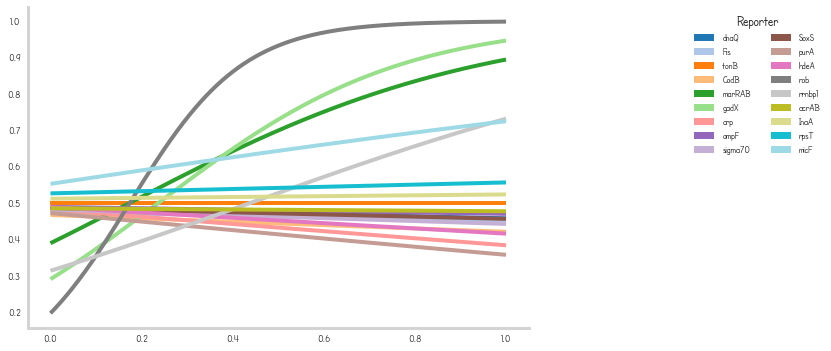

In [130]:
### logistic regression plots
plt.close('all')    
def model(x):
    return 1 / (1 + np.exp(-x))

def information_calculator(px):
    return 1-(-px*np.log2(px)-(1-px)*np.log2(1-px))
recs=[]

fig,ax=plt.subplots()

strains=data['Strain'].unique()
colorz = cm.tab20(np.linspace(0, 1, len(strains)))
values=[]
for z,strain in enumerate(strains):
    sliceo=data[data['Strain']==strain]
    maxval=len(sliceo[~np.isnan(sliceo['Time of Death'])])
    traj=[]

    for t in range(61):
        traj.append((maxval-len(sliceo[sliceo['Time of Death']<=t]))/maxval)


    try:
        ind=next(x[0] for x in enumerate(traj) if x[1] < .5)
        data[data['Strain']==strain]['alive']=list(data[data['Strain']==strain]['Time of Death']>=ind)

    except:
        print(strain+' cells do not die enough')
        ind=61
        data[data['Strain']==strain]['alive']=list(data[data['Strain']==strain]['Time of Death']>=ind)

    
    clf = linear_model.LogisticRegression(C=1e5, solver='lbfgs')


    dead=sliceo[sliceo['Time of Death']<=ind]['Fluor1 mean'].values
    alive=sliceo[sliceo['Time of Death']>ind]['Fluor1 mean'].values

    data_tot=np.concatenate((dead, alive))
    clf.fit(data_tot.reshape(-1, 1) , np.concatenate((np.zeros(len(dead)), np.ones(len(alive)))).reshape(-1, 1) )
    X_test=np.linspace(min(data_tot),max(data_tot),1000)

    loss = model(X_test * clf.coef_ + clf.intercept_).ravel()
    ax.plot((X_test-min(data_tot))/(max(data_tot)-min(data_tot)), loss, color=colorz[z])
    recs.append(mpatches.Rectangle((0, 0), 1, 1, fc=colorz[z]))



barfig.savefig('figures/information_bar.pdf',dpi=300)


ax.legend(recs, strains, title='Reporter', loc=1,ncol=2,bbox_to_anchor=(1.6, 1))

fig.savefig('figures/logistic.pdf',dpi=300)
fig

In [129]:
recs

[]

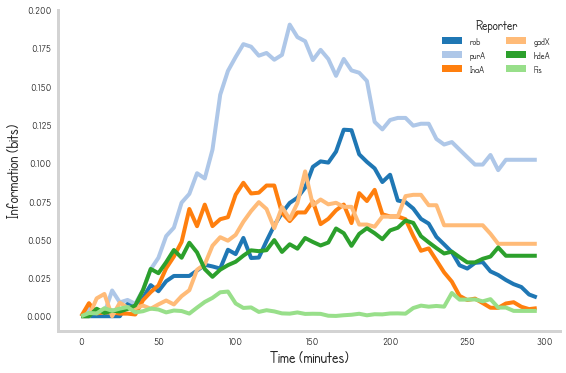

In [148]:
#Information over time and barchart
plt.close('all')    
def model(x):
    return 1 / (1 + np.exp(-x))

def information_calculator(px):
    vals=1-(-px*np.log2(px)-(1-px)*np.log2(1-px))
    vals[np.isnan(vals)]=1
    return vals

def entropy_calculator(px):
    vals=(-px*np.log2(px)-(1-px)*np.log2(1-px))
    vals[np.isnan(vals)]=0
    return vals

barfig,barax=plt.subplots()
fig,ax=plt.subplots()
barfig,barax=plt.subplots()
strains=data['Strain'].unique()
colorz = cm.tab20(np.linspace(0, 1, len(strains)))
values=[]
#strainz=['gadX']
strainz=['rob','purA','InaA','gadX','hdeA','Fis']
#strainz=strains
recs=[]
for z,strain in enumerate(strainz):
    sliceo=data[data['Strain']==strain]
    sliceo=sliceo[~np.isnan(sliceo['Time of Death'])]
    maxval=len(sliceo)
    traj=[]

    for t in range(61):
        traj.append((maxval-len(sliceo[sliceo['Time of Death']<=t]))/maxval)
    InitialAu=sliceo['Fluor1 mean']
    Deathtime=sliceo['Time of Death']

    d = {'InitialAu': InitialAu, 'DeathTime': Deathtime}
    df = pd.DataFrame(data=d)

    df=df.dropna()
    s={'fluor':df['InitialAu'],'death':df['DeathTime']}
    sd=pd.DataFrame(s)
    sd=sd.sort_values(by='fluor')
    n_splits=4
    rez=np.array_split(sd, n_splits)
    column_num=62
    bins=np.arange(column_num)
    grid=np.zeros((n_splits,column_num-1))
    labels=np.zeros((n_splits,column_num-1))
    mins=[]

    for x in range(n_splits):
        grid[x,:]=np.cumsum(np.histogram(rez[x].death, bins=bins)[0]/len(rez[x].death))
    
    value_traj=np.nanmean(information_calculator(grid),0)-information_calculator(np.asarray(traj))
    errors=[np.asarray(list(ssp.proportion_confint(int(x*len(InitialAu)), len(InitialAu), alpha=0.05, method='normal'))) for x in traj ]

    
    recs.append(mpatches.Rectangle((0, 0), 1, 1, fc=colorz[z]))


    ax.plot(np.arange(column_num-2)*5,value_traj[:-1],color=colorz[z],label=strain)
    means=value_traj[:-1]
    
    errors=[np.asarray(list(ssp.proportion_confint(int(x*len(InitialAu)), len(InitialAu), alpha=0.05, method='normal'))) for x in traj ]
    
    error_down=[entropy_calculator(x)[0] for x in errors]
    error_up=[entropy_calculator(x)[1] for x in errors]

    #ax.fill_between(np.arange(column_num-2)*5,  error_down[:-1], error_up[:-1], color=colorz[z], alpha=0.5)
    
    try:
        ind=next(x[0] for x in enumerate(traj) if x[1] < .5)
        
    except:
        print(strain+' cells do not die enough')
        ind=60
        
    values.append(value_traj[ind])

d = {'values': values, 'strains': strainz}
df = pd.DataFrame(data=d)
df.sort_values('values', ascending=True).plot.bar(x='strains',ax=barax,color='#e684ae')
barax.set_ylabel('Information (bits)')



#ax.legend()
#ax.set_ylim([0,0.12])
ax.set_xlabel('Time (minutes)')
ax.set_ylabel('Information (bits)')
barfig.savefig('figures/bar.pdf')
ax.legend(recs, strainz, title='Reporter', loc=1,ncol=2,bbox_to_anchor=(1, 1))

fig.savefig('figures/information_overtime.pdf')

fig



In [134]:
#[entropy_calculator(x)[0] for x in errors]
plt.close('all')
fig,ax=plt.subplots()

#errors=[np.asarray(list(ssp.proportion_confint(int(x*len(InitialAu)), len(InitialAu), alpha=0.05, method='normal'))) for x in traj ]

error_down=np.asarray([x[0] for x in errors])
error_up=np.asarray([x[1] for x in errors])
trajo=np.asarray(traj)
ax.plot(np.arange(len(trajo))*5,trajo)

ax.fill_between(np.arange(len(trajo))*5,  error_down, error_up, color=colorz[z], alpha=0.5)

fig.savefig('neo.pdf')

In [ ]:
entropy_calculator(error_down)

In [3]:

#### Distribution animations
plt.close('all')
fig,ax=plt.subplots()
sliceo=data[data['Strain']=='rob']

traj=[]
xvect=np.linspace(0,60*5,61)
for t in range(61):
    traj.append((maxval-len(sliceo[sliceo['Time of Death']<=t]))/maxval)

ind=next(x[0] for x in enumerate(traj) if x[1] < 0.1)
        
datum=sliceo['Fluor1 mean']
datum2=sliceo['Fluor1 mean'][sliceo['Time of Death']>=ind]
# probs, bons = np.histogram(sliceo['Fluor1 mean'], normed='True', bins=bins)
# ax.plot(bons[1:], np.cumsum(probs / np.sum(probs)),  drawstyle='steps-pre')
# probs, bons = np.histogram(sliceo['Fluor1 mean'][sliceo['Time of Death']>=ind], normed='True', bins=bins)
# ax.plot(bons[1:], np.cumsum(probs / np.sum|(probs)),  drawstyle='steps-pre')
# fig


density = gaussian_kde(datum)
xs = np.linspace(500,16000,200)
density.covariance_factor = lambda : .25
density._compute_covariance()
ax.plot(xs,density(xs))

density = gaussian_kde(datum2)
density.covariance_factor = lambda : .25
density._compute_covariance()
ax.plot(xs,density(xs))

ax.set_xscale('log')
fig

NameError: name 'maxval' is not defined

In [62]:
### animation of distribution
plt.close('all')
fig_animate,ax=plt.subplots()

lines=[]
sliceos=[data[data['Strain']=='rob'],data[data['Strain']=='purA']]
colors=['#e684ae','teal']
for n,l in enumerate(sliceos):
    lines.append(ax.plot([],[],color=colors[n]))
xs = np.linspace(500,16000,200)
ax.set_xlim([500,16000])
ax.set_xscale('log')
ax.set_ylim([0,.0006])
def animate(z):
    for j,sliceo in enumerate(sliceos):
        density = gaussian_kde(sliceo['Fluor1 mean'][sliceo['Time of Death']>=z])
        density.covariance_factor = lambda : .25
        density._compute_covariance()
        ax.plot(xs,density(xs),color='grey',alpha=0.05)

        lines[j][0].set_data(xs,density(xs))

    return lines

anim3 = animation.FuncAnimation(fig_animate, animate,frames=61,  blit=False)
plt.tight_layout()
anim3.save('evolution.mp4', writer='ffmpeg',bitrate=1800)
#HTML(anim3.to_html5_video())

In [162]:
#heatmaps

#dataload

for strain in strains:
    plt.close('all')
    sliceo=data[data['Strain']==strain]



    InitialAu=sliceo['Fluor1 mean']
    Deathtime=sliceo['Time of Death']

    d = {'InitialAu': InitialAu, 'DeathTime': Deathtime}
    df = pd.DataFrame(data=d)
    df['DeathTime'][df['DeathTime']==-1]=62
    df['DeathTime'][df['DeathTime']==0]=np.nan

    fig,ax=plt.subplots()
    df=df.dropna()
    s={'fluor':df['InitialAu'],'death':5*df['DeathTime']}
    sd=pd.DataFrame(s)
    sd=sd.sort_values(by='fluor')
    n_splits=10
    rez=np.array_split(sd, n_splits)
    column_num=10
    bins=np.linspace(0,300,column_num)-10
    grid=np.zeros((n_splits,column_num-1))
    labels=np.zeros((n_splits,column_num-1))
    mins=[]
    
    for x in range(n_splits):
        mino,maxo=min(rez[x].fluor),max(rez[x].fluor)
        grid[x,:]=np.cumsum(np.histogram(rez[x].death, bins=bins)[0]/len(rez[x].death))
        labels[x,:]=np.histogram(rez[x].death, bins=bins)[0]
        mins.append(str((x+1)*10)+'%')

    sns.heatmap(np.flipud(grid)*100,yticklabels=np.flipud(mins),xticklabels=[int(u) for u in bins[1:]],cmap="rainbow",vmin=0, vmax=100,cbar_kws={'label': '% chance of death'})
    ax.set_yticks(np.arange(len(np.flipud(mins)))+1)
    plt.yticks(rotation=0) 

    ax.set_xlabel('Time (minutes)')
    ax.set_ylabel('Fluorescence at t0 (A.U)')
    ax.set_title(strain)
    fig.savefig('figures/'+strain+'_heatmap.pdf',dpi=300)